In [2]:
start_x = 200
end_x = 1000
T = 60 # seconds

60

In [293]:
using JuMP,Gurobi

m = Model(solver=GurobiSolver(OutputFlag = 0))

@variable(m, x[1:T])    # resulting position
@variable(m, v[1:T])    # resulting velocity
@variable(m, z[1:T], Bin)
@variable(m, z_x[1:T], Bin)
@variable(m, u[1:T-1])  # thruster input
@variable(m, w[1:T-1])
@variable(m, z_xx[1:T-1], Bin)
@variable(m, z_z[1:T], Bin)
@variable(m, z_x_x[1:T], Bin)

@constraint(m, x[1] == start_x)
@constraint(m, v[1] == 0)
@constraint(m, x[T] == end_x)
@constraint(m, v .<= 26.822*z) # maximum speed constraint
@constraint(m, v[T] == 0)     # stop at the end
@constraint(m, total_dist, sum(x[i] - x[i-1] for i in 2:T) == end_x - start_x) #cover the total trip

for i=1:T
    @constraint(m, x[i] - 205 <= 1000*z_x[i])   # if x >=206 then z=1
    @constraint(m, v[i] - 22.352 >= -22.352*(2-z_x[i]-z_x_x[i])) # if z_x + z_x_x=1 then v>=22.352
    @constraint(m, x[i] - 205 >= -205*(1-z_x[i])) # if z_x=1 then x>= 206 
                
    @constraint(m, x[i]-995 >= -795z_x_x[i] + 0.1(1-z_x_x[i])) # if x<=995 then z=1
    @constraint(m, x[i]-995 <= 1000(1-z_x_x[i]))  # if z=1 then x<=995
      
end
            

for i=2:T-1
    #@constraint(m, x[i]-end_x >= -800z_xx[i])    # if x<=end then z_xx=1
    #@constraint(m, x[i]-x[i+1] + 0.1 <= 800(1-z_xx[i])) # if z_xx=1 then x[i]<=x[i+1] - 0.1
end
            
for i=1:T-1
    #@constraint(m, x[i]-x[i+1]+0.1 <= 0)
end

for i=1:T
    @constraint(m, x[i]-1000 <= 1000z_z[i] - 0.1(1-z_z[i]))
    @constraint(m, x[i]-1000>=-800(1-z_z[i]))
end

#@constraint(m, v[2:20] .>= 22.352)
#@constraint(m, x[3]-x[2] >= 5)
#@constraint(m, v[2] >= 1)
#@constraint(m, v[10:T] .>= 22.352*z[10:T])
#for i in 2:10
 #   @constraint(m, v[i] >= 5)
 #   @constraint(m,v[i] >= v[i-1])
#end

@constraint(m, w .>= u)
@constraint(m, -w .<= u)
            
# satisfy the dynamics
for i = 1:T-1
    @constraint(m, x[i+1] == x[i] + v[i])
    @constraint(m, v[i+1] == v[i] + u[i])
end
            
#@expression(m, count1000, sum(1 for i in 1:T if x[i] == 1000.0 ))       

# minimize 2-norm
#@objective(m, Min, sum(u[1:10].^2) + sum(w[11:T-1].^2))
@objective(m, Min, sum(u.^2) - sum(z_z))

solve(m)
uopt = getvalue(u);

In [294]:
xopt = getvalue(x)
vopt = getvalue(v)
z_xopt = getvalue(z_x)
for i in 1:T
    if xopt[i] >= 206
        println("x=", xopt[i], " v=", vopt[i], " z_x=", z_xopt[i], " t=", i)
    end
end

x=218.68832815964524 v=22.352 z_x=1.0 t=4
x=241.0403281596452 v=22.721844789356986 z_x=1.0 t=5
x=263.7621729490022 v=23.067033259423503 z_x=1.0 t=6
x=286.8292062084257 v=23.387565410199556 z_x=1.0 t=7
x=310.2167716186252 v=23.683441241685145 z_x=1.0 t=8
x=333.9002128603104 v=23.95466075388027 z_x=1.0 t=9
x=357.85487361419064 v=24.201223946784925 z_x=1.0 t=10
x=382.0560975609756 v=24.423130820399116 z_x=1.0 t=11
x=406.47922838137475 v=24.620381374722843 z_x=1.0 t=12
x=431.0996097560976 v=24.792975609756102 z_x=1.0 t=13
x=455.89258536585373 v=24.940913525498896 z_x=1.0 t=14
x=480.83349889135263 v=25.064195121951226 z_x=1.0 t=15
x=505.89769401330386 v=25.162820399113087 z_x=1.0 t=16
x=531.060514412417 v=25.236789356984485 z_x=1.0 t=17
x=556.2973037694014 v=25.286101995565417 z_x=1.0 t=18
x=581.5834057649669 v=25.31075831485588 z_x=1.0 t=19
x=606.8941640798228 v=25.31075831485588 z_x=1.0 t=20
x=632.2049223946786 v=25.286101995565417 z_x=1.0 t=21
x=657.4910243902441 v=25.236789356984485 z_x

In [295]:
vopt = getvalue(v)
print(vopt)

[-0.0,5.0,13.6883,22.352,22.7218,23.067,23.3876,23.6834,23.9547,24.2012,24.4231,24.6204,24.793,24.9409,25.0642,25.1628,25.2368,25.2861,25.3108,25.3108,25.2861,25.2368,25.1628,25.0642,24.9409,24.793,24.6204,24.4231,24.2012,23.9547,23.6834,23.3876,23.067,22.7218,22.352,4.9,-7.84439e-12,0.0,-3.63798e-12,0.0,-6.0254e-12,0.0,0.0,0.0,-2.95586e-12,0.0,0.0,-4.77485e-12,0.0,0.0,-7.12436e-13,-1.24676e-12,-1.60299e-12,-1.7811e-12,-1.7811e-12,-1.60298e-12,-1.24676e-12,-7.12434e-13,0.0,-0.0]

In [296]:
print(getvalue(x))

[200.0,200.0,205.0,218.688,241.04,263.762,286.829,310.217,333.9,357.855,382.056,406.479,431.1,455.893,480.833,505.898,531.061,556.297,581.583,606.894,632.205,657.491,682.728,707.891,732.955,757.896,782.689,807.309,831.732,855.933,879.888,903.572,926.959,950.026,972.748,995.1,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0]

In [297]:
print(getvalue(z_z))

[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]

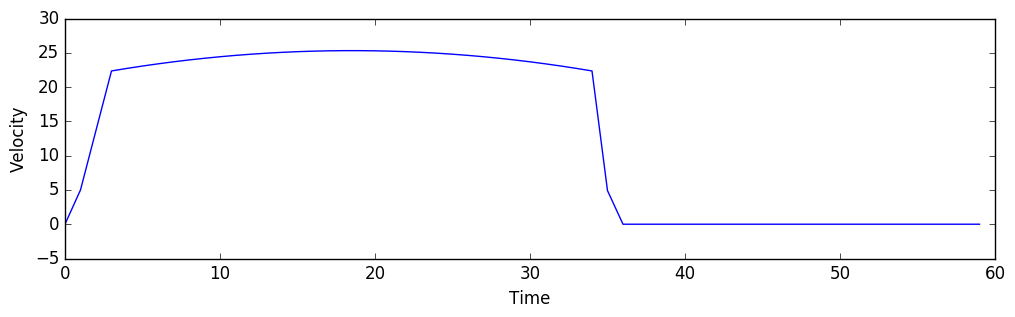

In [298]:
using PyPlot
figure(figsize=(12,3))
plot( 0:T-1, vopt);
xlabel("Time"); ylabel("Velocity");

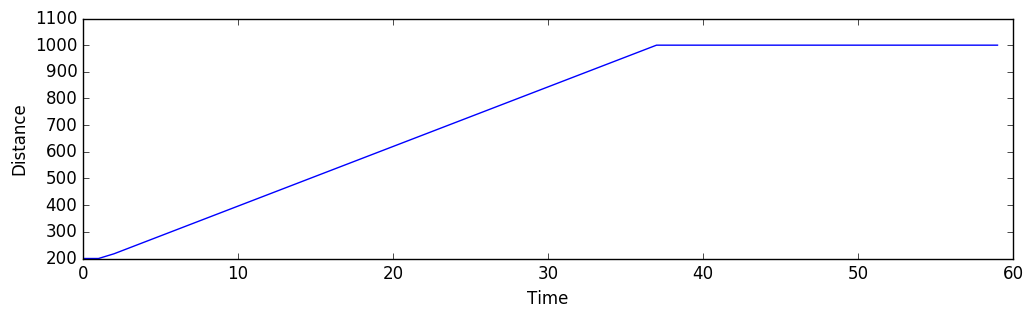

In [292]:
using PyPlot
figure(figsize=(12,3))
plot( 0:T-1, xopt);
xlabel("Time"); ylabel("Distance");